### **Preprocessing** ###


This notebook downloads and preprocesses the RAMP data package (RAMP-DATA-V0), which comprises over 100k image-label in TIF-GEOJSON formats and 22 regional folders. The resulting output of this notebook is YOLO-DATA-V1 dataset. YOLO-DATA-V2 and YOLO-DATA-V3 datasets were created using the Pruning notebook.

Below are the key highlights accomplished in this notebook.

1. Data Exploration
    
 - Download from Gdrive and unzip the RAMP data package.
 - Completed basic data integrity checks.
 - Counted the image and label files and confirmed that each image has a label with the matching name.
 - Checked the shape of the images; this step revealed issues with the Shanghai and Paris subfolders.
 - Identify background images by filename the image-label and compute the total percentage.

2. Enhance the dataset

 - Create a dataframe for analysis and data control.
 - Set Shanghai and Paris subfolders from the dataset by flagging 'use' to False for image shape is not (256, 256, 3).
 - Set 'use' flag to False randomly for 13% of background images to reduce from 18% to 5%.
 - Indentify images found with incorrect image-label in the exclusions_list.txt.

3. Convert RAMP (TIF/GEOJSON) to YOLO (JPG/TXT)

 - Image-label pairs were randomly assigned to train-val-test folders using a 70-15-15 split.
 - Generate text files based on the YOLO's segmentation format from the GEOJSON and TIF files. Polygons were extracted from each GEOJSON file and aligned with the location information embedded in the TIF. Note: 0,0 is the top, left, and coordinates normalized over 0, 1.
 - Convert the TIF images to JPG at quality level 100.


Note: A GPU is not required for preprocessing. Due to the numerous disk i/o operations, this notebook is preferred over Google Colab for local running.

In [ ]:
!pip3 install -q rasterio
!pip3 install -q pyproj

In [ ]:
import os
import glob
import json
import cv2
import json
import pandas as pd
import matplotlib.pyplot as plt
import random
from pyproj import Transformer
import rasterio
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import yaml
import gc
from tqdm import tqdm

In [ ]:
DATA_FOLDERS = 'ramp_data/ramp_*'

# Check if the data is already downloaded
if not os.path.exists('ramp_data'):
    print('Downloading data...')
    !gdown --fuzzy https://drive.google.com/file/d/11_FBrzgwgSHO6fDwjDvWFkJWLTiK2j_O/view?usp=sharing
    print('Unzipping data...')
    !unzip -q data0*.zip
else:
    print('Data already downloaded')

# Download exclusions_list.txt from gdrive data folder
!gdown --fuzzy https://drive.google.com/file/d/1vCtCYLbzluJyNKjq_KVYXHHuq3Bxo8z1/view?usp=sharing
!unzip exclusion*.zip

Downloading...
From (original): https://drive.google.com/uc?id=11_FBrzgwgSHO6fDwjDvWFkJWLTiK2j_O
From (redirected): https://drive.google.com/uc?id=11_FBrzgwgSHO6fDwjDvWFkJWLTiK2j_O&confirm=t&uuid=ea9d6ab2-85b9-4090-b40a-780ad196f5a9
To: /content/data0_ramp_data.zip
100% 15.2G/15.2G [04:01<00:00, 63.1MB/s]
Unzipping data...
Downloading...
From: https://drive.google.com/uc?id=1vCtCYLbzluJyNKjq_KVYXHHuq3Bxo8z1
To: /content/exclusion_list.txt.zip
100% 1.43k/1.43k [00:00<00:00, 6.11MB/s]
Archive:  exclusion_list.txt.zip
replace exclusion_list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def find_files():
    """
    Find chip (.tif) and label (.geojson) files in the specified folders.

    Returns:
    cwps (list): List of chip filenames with path.
    lwps (list): List of label filenames with path.
    base_folders (list): List of base folder names.
    """

    # Find the folders
    data_folders = glob.glob(DATA_FOLDERS)

    # Create a list to store chip (.tif), mask (.mask.tif), and label (.geojson) filenames with path
    cwps = []
    lwps = []

    # Create a list to store the base folder names
    base_folders = []

    for folder in data_folders:
        # Pattern to match all .tif files in the current folder, including subdirectories
        tif_pattern = f"{folder}/**/*.tif"

        # Find all .tif files in the current 'training*' folder and its subdirectories
        found_tif_files = glob.glob(tif_pattern, recursive=True)

        # Filter out .mask.tif files and add the rest to the tif_files list
        for file in found_tif_files:
            if file.endswith('.tif'):
                cwps.append(file)

        # Pattern to match all .geojson files in the current folder, including subdirectories
        geojson_pattern = f"{folder}/**/*.geojson"

        # Find all .geojson files
        found_geojson_files = glob.glob(geojson_pattern, recursive=True)

        # Add found .geojson files to the geojson_files list
        lwps.extend(found_geojson_files)

    # Sort the lists
    cwps.sort()
    lwps.sort()

    # Assert that the the number files for each type are the same
    assert len(cwps) == len(lwps), "Number of tif files and label files do not match"

    # Function to check that the filenames match
    for n, cwp in enumerate(cwps):
        c = os.path.basename(cwp).replace('.tif', '')
        l = os.path.basename(lwps[n]).replace('.geojson', '')

        assert c == l, f"Chip and label filenames do not match: {c} != {l}"

        base_folders.append(cwp.split('/')[1])

    return cwps, lwps, base_folders

# Call the function and print the number of found files
cwps, lwps, base_folders = find_files()
print('Found {} chip files'.format(len(cwps)))
print('Found {} label files\n'.format(len(lwps)))

# Print message if all filenames match
print('All filenames match; each tif has a label!')

Found 100015 chip files
Found 100015 label files

All filenames match; each tif has a label!


In [ ]:
def check_shapes(iwps):
    """
    Check the shapes of image files and store them in a dictionary.

    Parameters:
    iwps (list): A list of image files with paths.

    Returns:
    tuple: A tuple containing two elements:
        - shapes_dict (dict): A dictionary where the keys are the image shapes and the values are the counts.
        - shapes (list): A list of the shapes of the chip files in the same order as the input list.
    """
    # Create a dictionary to store the shape of the chip files
    shapes_dict = {}
    shapes = []

    for iwp in tqdm(iwps):
        # Read the chip file
        shape = cv2.imread(iwp, -1).shape

        # Store the shape in the dictionary
        if str(shape) in shapes_dict:
            shapes_dict[str(shape)] += 1
        else:
            shapes_dict[str(shape)] = 1

        shapes.append(shape)

    # Return the dictionary
    return shapes_dict, shapes

# Get shapes data
shapes_data = check_shapes(cwps)

# Print the shape of the first chip file
print(f'Chip shapes with counts are: {shapes_data[0]}')

100%|██████████| 100015/100015 [05:01<00:00, 331.32it/s]

Chip shapes with counts are: {'(256, 256, 3)': 95414, '(256, 256)': 4601}


In [ ]:
def get_geo_data(iwp):
    """
    Extracts geo data from a geotif.

    Parameters:
    iwp (str): The image file with path.

    Returns:
    dict: A dictionary containing the extracted geo data. The dictionary includes the following keys:
        - 'left': The left coordinate of the bounding box.
        - 'right': The right coordinate of the bounding box.
        - 'top': The top coordinate of the bounding box.
        - 'bottom': The bottom coordinate of the bounding box.
        - 'width': The width of the bounding box.
        - 'height': The height of the bounding box.
        - 'crs': The coordinate reference system (CRS) of the geotif.
    """
    # Open the image file in binary mode ('rb') for reading Exif data
    with rasterio.open(iwp) as src:

        if src.crs is None:
            raise ValueError("No CRS found in the image file. Please check the file and try again.")
        elif src.bounds is None:
            raise ValueError("No bounds found in the image file. Please check the file and try again.")

        # Convert the bounds to the expected format
        transformer = Transformer.from_crs(src.crs, 'EPSG:4326')
        left, bottom = transformer.transform(src.bounds.left, src.bounds.bottom)
        right, top = transformer.transform(src.bounds.right, src.bounds.top)
        width = right - left
        height = top - bottom

        # Collect and return the extracted geo data
        results = {'left': left, 'right': right, 'top': top, 'bottom': bottom, 'width': width, 'height': height, 'crs': src.crs.to_string()}

        return results

In [ ]:
def check_and_clamp(values):
    """
    Check and clamp the values in a nested list.

    Parameters:
    values (list): A nested list of values to be checked and clamped.

    Returns:
    list: A nested list of clamped values.

    """
    # Initialize an empty list to store the clamped values
    clamped_values = []

    # Iterate over each sublist in the list
    for sublist in values:
        # Use a list comprehension to check and clamp each value in the sublist
        clamped_sublist = [[max(0, min(1, value)) for value in pair] for pair in sublist]

        # Add the processed sublist to the clamped_values list
        clamped_values.append(clamped_sublist)

    return clamped_values

# Example usage
# This function clamps polygons coordinates that go outside of the coordinate bounds of the chip.
# YOLO requires all coordinates be in the range of (0, 1)
# test = [[[0.998301, 0.642099], [0.997246, 1.417954], [-0.99515, 0.404696], [0.997182, 0.40438], [0.996855, 0.334872], [0.926036, 0.346056], [0.973166, 0.646062], [0.998301, 0.642099]]]
# print(check_and_clamp(test))

In [ ]:
def flatten_list(nested_list):
    """
    Flattens a nested list into a single flat list.

    Parameters:
    nested_list (list): The nested list to be flattened.

    Returns:
    list: The flattened list.
    """
    flat_list = []

    # Iterate over all the elements in the given list
    for item in nested_list:
        # Check if the item is a list itself
        if isinstance(item, list):
            # If the item is a list, extend the flat list by adding elements of this item
            flat_list.extend(flatten_list(item))
        else:
            # If the item is not a list, append the item itself
            flat_list.append(item)
    return flat_list

In [ ]:
def convert_coordinates(coordinates, geo_dict):
    """
    Convert coordinates from one coordinate system to another based on the provided geo_dict.

    Args:
        coordinates (list): A list of coordinate sets.
        geo_dict (dict): A dictionary containing information about the coordinate system.

    Returns:
        list: The converted coordinates.

    Raises:
        AssertionError: If the maximum coordinate value is greater than 1 or the minimum coordinate value is less than 0.
    """
    # Iterate over the outer list
    for i in range(len(coordinates)):
        # Iterate over each coordinate set in the inner list
        for j in range(len(coordinates[i])):
            if geo_dict['crs'] == 'EPSG:4326':
                # Convert the coordinates for the EPSG:4326
                coordinates[i][j] = [round((coordinates[i][j][0] - geo_dict['left'])/geo_dict['width'], 6), \
                                    round((geo_dict['top'] - coordinates[i][j][1])/geo_dict['height'], 6)]
            else:
                # Convert the coordinates for not EPSG:4326
                coordinates[i][j] = [round((coordinates[i][j][0] - geo_dict['bottom'])/geo_dict['height'], 6), \
                                    round((geo_dict['right'] - coordinates[i][j][1])/geo_dict['width'], 6)]

    coordinates = check_and_clamp(coordinates)

    # Make sure that the coordinates are within the expected range
    assert max(flatten_list(coordinates)) <= 1, "The maximum coordinate value is greater than 1"
    assert min(flatten_list(coordinates)) >= 0, "The minimum coordinate value is less than 0"

    return coordinates

In [ ]:
def write_yolo_file(iwp, folder, class_index=0):
    """
    Writes YOLO label file based on the given image with path and class index.

    Args:
        iwp (str): The image with path.
        class_index (int, optional): The class index for the YOLO label. Defaults to 0.

    Returns:
        None
    """

    # Get the GeoJSON filename with path from the chip filename with path
    lwp = iwp.replace(".tif", ".geojson").replace("source", "labels")

    # Create the YOLO label filename with path from the chip filename with path
    ywp = os.path.join(f'ramp_data_yolo/folder/labels/', iwp.split('/')[-1].replace('.tif', '.txt')).replace('folder', folder)

    # Create the YOLO label folder if it does not exist
    os.makedirs(os.path.dirname(ywp), exist_ok=True)

    # Remove the YOLO label file if it already exists
    if os.path.exists(ywp):
        os.remove(ywp)

    # Fetch the chip's Exif data
    geo_dict = get_geo_data(iwp)

    # Open the GeoJSON file
    with open(lwp, 'r') as file:
        data = json.load(file)

    # Initialize the polygon count
    polygon_count = 0

    # Navigate through the GeoJSON structure
    for feature in data['features']:
        if feature['geometry']['type'] == 'Polygon':
            # Increment the polygon count
            polygon_count += 1

            # Get the coordinates of the polygon
            coordinates = feature['geometry']['coordinates']

            # Convert the coordinates
            new_coordinates = flatten_list(convert_coordinates(coordinates, geo_dict))
            new_coordinate_str = ' '.join(map(str, flatten_list(new_coordinates)))

            # Write the converted coordinates to a file
            with open(ywp, 'a+') as file:
                # Move the file pointer to the start of the file to check its contents.
                file.seek(0)  # Go to the beginning of the file
                first_character = file.read(1)  # Read the first character to determine if the file is empty

                # If the first character does not exist, the file is empty
                if not first_character:
                    # Write the first string without a new line before it
                    file.write(f'{class_index} ' + new_coordinate_str)

                else:
                    # The file is not empty, write the new string on a new line
                    file.write(f'\n{class_index} ' + new_coordinate_str)

    if polygon_count == 0:
        # Open the file in write mode, which creates a new file if it doesn't exist
        with open(ywp, 'w') as file:
            pass  # No need to write anything, just creating the file

In [ ]:
def convert_tif_to_jpg(cwp, folder, ql=100):
    """
    Converts a TIFF image file to JPEG format.

    Parameters:
    cwp (str): The path to the TIFF image file.
    ql (int): The quality level of the JPEG image (default is 100).

    Returns:
    None
    """
    # Open the tif image file
    with Image.open(cwp) as img:
        # Convert the image to RGB and save it as a JPEG
        rgb_img = img.convert('RGB')

        # Define the output path with .jpg extension
        jwp = os.path.join('ramp_data_yolo/folder/images/', cwp.split('/')[-1].replace('.tif', '.jpg')).replace('folder', folder)

        # Create the output folder if it does not exist
        os.makedirs(os.path.dirname(jwp), exist_ok=True)

        # Save the image at quality level ql
        rgb_img.save(jwp, "JPEG", quality=ql)

        # Print the output path
        return (f'Writing: {jwp}')

In [ ]:
def get_polygon_count(lwp):
    """
    Count the number of polygons in a GeoJSON file.

    Parameters:
    lwp (str): The path to the GeoJSON file.

    Returns:
    int: The number of polygons in the GeoJSON file.
    """
    # Open the GeoJSON file
    with open(lwp, 'r') as file:
        data = json.load(file)

    # Initialize the polygon count
    polygon_count = 0

    # Navigate through the GeoJSON structure
    for feature in data['features']:
        if feature['geometry']['type'] == 'Polygon':
            # Increment the polygon count
            polygon_count += 1

    return polygon_count

In [ ]:
# 1. Create a DataFrame with the filenames, basefolders, polygon counts, and image shapes.
# 2. Add a 'use' field that will be set to False for image-label pairs that will not be used.
#     a. Randomly set 'use' to False to reach the background images to the Z_TARGET of 5%.
#     b. Set 'use' to False when shape is not 256, 256, 3.
# 3. Review counts to verify the changes.

Z_TARGET_PERCENTAGE = 0.05

# Create a list to store the polygon counts
polygon_counts = []

# Loop through the label files and store the polygon count of each file
for lwp in tqdm(lwps):
    polygon_counts.append(get_polygon_count(lwp))

# Create a list of chip and label filenames
fwps = [os.path.basename(lwp).replace('.geojson', '.tif') for lwp in lwps]

# Create a DataFrame to store the chip, mask, and label filenames and the polygon counts
df = pd.DataFrame({
    'base_folder': base_folders,
    'cwp': cwps,
    'fwp': fwps,
    'polygon_count': polygon_counts,
    'shape': shapes_data[1],
    'use': True
})

# Figure out how many zero count images to use
z_count = len(df[df['polygon_count'] == 0])
z_target = int(round(len(df)*Z_TARGET_PERCENTAGE, 0))

# Filter the DataFrame where polygon_count is 0
condition = df['polygon_count'] == 0
subset_df = df[condition]

# Randomly select 5001 indices from this subset and set use to True
indices_to_set_true = np.random.choice(subset_df.index, size=5001, replace=False)
df.loc[indices_to_set_true, 'use'] = True

# Set 'use' to False for the remaining indices in the subset
remaining_indices = subset_df.index.difference(indices_to_set_true)
df.loc[remaining_indices, 'use'] = False

# Set 'use' to False where shape is not (256, 256, 3)
df.loc[df['shape'] != (256, 256, 3), 'use'] = False

# Optional: Verify the changes
print("Count of 'True' in 'use' where polygon_count is 0:", df[(df['polygon_count'] == 0) & (df['use'])].shape[0])
print("Count of 'False' in 'use' where polygon_count is 0:", df[(df['polygon_count'] == 0) & (~df['use'])].shape[0])
print('Percentage of rows where polygon count is 0:', round(100*df[df['polygon_count'] == 0].shape[0]/df.shape[0], 1))
print('Percentage of rows where poloygon count is 0 and use is True:', round(100*df[(df['polygon_count'] == 0) & (df['use'])].shape[0]/df.shape[0], 1))
print('\nTotal number of rows:', df.shape[0])

# Check for duplicate filenames
duplicates = df.duplicated(subset='fwp')
duplicated_files = df[duplicates]
print(f'\nNumber of duplicated files: {duplicated_files.shape[0]}')

# Print the head of the df
print(f'\n{df.head()}')

100%|██████████| 100015/100015 [01:14<00:00, 1345.07it/s]


Count of 'True' in 'use' where polygon_count is 0: 4561
Count of 'False' in 'use' where polygon_count is 0: 13796
Percentage of rows where polygon count is 0: 18.4
Percentage of rows where poloygon count is 0 and use is True: 4.6

Total number of rows: 100015

Number of duplicated files: 0

        base_folder                                                cwp  \
0  ramp_accra_ghana  ramp_data/ramp_accra_ghana/source/000c57e6-74f...   
1  ramp_accra_ghana  ramp_data/ramp_accra_ghana/source/003280f5-57a...   
2  ramp_accra_ghana  ramp_data/ramp_accra_ghana/source/003b9eeb-f27...   
3  ramp_accra_ghana  ramp_data/ramp_accra_ghana/source/003d3a2f-5f0...   
4  ramp_accra_ghana  ramp_data/ramp_accra_ghana/source/006540ac-367...   

                                        fwp  polygon_count          shape  \
0  000c57e6-74f7-4d78-ae65-5b7a6c50ce68.tif             27  (256, 256, 3)   
1  003280f5-57ac-4e31-9011-ff081dce6208.tif              2  (256, 256, 3)   
2  003b9eeb-f276-4804-b4cc-7cdac

In [ ]:
def aggregate_data(df):
    """
    Aggregates the data in the given DataFrame by grouping it based on the 'base_folder' column.
    Calculates the count of images, sum of 'use' column, and count of 'polygon_count' where the value is 0.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data to be aggregated.

    Returns:
        pandas.DataFrame: The aggregated DataFrame with columns 'img_count', 'use', and 'z_count'.
    """
    # Group by 'base_folder' and aggregate
    df_bf = df.groupby('base_folder').agg(
        img_count=('cwp', 'count'),
        use=('use', 'sum'),
        z_count=('polygon_count', lambda x: (x == 0).sum())
    )

    return df_bf

# Aggregate data for analysis
aggregated_df = aggregate_data(df)
print(aggregated_df[['img_count', 'use', 'z_count']])

# Print the total number of files
print(f'\n\tTotal: \t\t{df.shape[0]}')

# Print the number of files to use
print(f'\tUsed: \t\t{df[df["use"]].shape[0]}')
print(f'\tNot Used: \t{df.shape[0] - df[df["use"]].shape[0]}')

                             img_count    use  z_count
base_folder                                           
ramp_accra_ghana                  1330   1315       19
ramp_barishal_bangladesh          3024   2842      253
ramp_bentiu_south_sudan           1789   1334      627
ramp_chittagong_bangladesh        5229   4241     1282
ramp_coxs_bazar_bangladesh        2375   2044      447
ramp_daressalaam_tanzania          566    512       79
ramp_dhaka_bangladesh            11905   9711     3061
ramp_hpa_an_myanmar               3667   3229      593
ramp_jashore_bangladesh           7310   6065     1736
ramp_karnataka_india              6288   5156     1540
ramp_les_cayes_haiti              1430   1194      317
ramp_lubumbashi_drc               8498   8303      264
ramp_manjama_sierra_leone         4671   4516      236
ramp_mesopotamia_st_vincent       3013   2782      311
ramp_muscat_oman                  2891   2667      304
ramp_mzuzu_malawi                 3357   3117      342
ramp_nairo

In [ ]:
# Split data it into train-val-test and convert label and image formats for YOLO model training.
# 1. Define SEED and train-val-test split percentages
# 2. Get the chip filenames where 'use'=True
# 3. Shuffle the and divide the chips to prevent biased data splitting.
# 4. Confirm the training, validation, and testing arrays to verify the correct split.
# 8. Write YOLO label files.
# 9. Convert image files from TIFF to JPEG.

SEED = 42
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

assert(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1), "The sum of the splits must be equal to 1"

print(f'Train-val-test split: {TRAIN_SPLIT}-{VAL_SPLIT}-{TEST_SPLIT}')

# Set the random seed
np.random.seed(SEED)

# Get the cwps
cwps = df[df['use']]['cwp'].values

# Shuffle indices
shuffled_indices = np.random.permutation(len(cwps))

# Calculate split indices for the specified split percentage
train_end = int(len(cwps) * TRAIN_SPLIT)
val_end = train_end + int(len(cwps) * VAL_SPLIT)

# Split the indices into training, validation, and testing
train_indices = shuffled_indices[:train_end]
val_indices = shuffled_indices[train_end:val_end]
test_indices = shuffled_indices[val_end:]

# Create train, val, and test arrays
train_cwps = cwps[train_indices]
val_cwps = cwps[val_indices]
test_cwps = cwps[test_indices]

# Output the results to verify
print(f'\nTrain array size: {len(train_cwps)}')
print(f'Validation array size: {len(val_cwps)}')
print(f'Test array size: {len(test_cwps)}\n')

# Check if the YOLO folder exists, if not create labels, images, and folders
if not os.path.exists('ramp_data_yolo'):
    # Create the folder
    os.makedirs('ramp_data_yolo')

    # Write the YOLO label files for the training set
    print('Generating training labels')
    for train_cwp in tqdm(train_cwps):
        write_yolo_file(train_cwp, 'train')

    # Write the YOLO label files for the validation set
    print('Generating validation labels')
    for val_cwp in tqdm(val_cwps):
        write_yolo_file(val_cwp, 'val')

    # Write the YOLO label files for the test set
    print('Generating test labels')
    for test_cwp in tqdm(test_cwps):
        write_yolo_file(test_cwp, 'test')

    # Convert the chip files to JPEG format
    print('Generating training images')
    for train_cwp in tqdm(train_cwps):
        convert_tif_to_jpg(train_cwp, 'train')

    print('Generating validation images')
    for val_cwp in tqdm(val_cwps):
        convert_tif_to_jpg(val_cwp, 'val')

    print('Generating test images')
    for test_cwp in tqdm(test_cwps):
        convert_tif_to_jpg(test_cwp, 'test')

else:
    print('Data already converted')

Train-val-test split: 0.7-0.15-0.15

Train array size: 58277
Validation array size: 12488
Test array size: 12489

Generating training labels


100%|██████████| 58277/58277 [14:58<00:00, 64.83it/s]


Generating validation labels


100%|██████████| 12488/12488 [02:48<00:00, 74.15it/s]


Generating test labels


100%|██████████| 12489/12489 [03:07<00:00, 66.75it/s]


Generating training images


100%|██████████| 58277/58277 [05:53<00:00, 165.03it/s]


Generating validation images


100%|██████████| 12488/12488 [01:12<00:00, 172.66it/s]


Generating test images


100%|██████████| 12489/12489 [01:20<00:00, 155.30it/s]


In [ ]:
# Delete the image-label pairs that are on the exclusion list

# Text file listing images flagged for removal
exclusion_list = []

# Load the rm list
with open('exclusion_list.txt', 'r') as file:
    exclusion_list = file.read().splitlines()

# Parent directory where the search should start
parent_directory = 'ramp_data_yolo'

# Loop over each filename
for fn in tqdm(exclusion_list):
    # Generate patterns for .jpg and .txt files
    jpg_pattern = f"{parent_directory}/*/images/{fn}.jpg"
    txt_pattern = f"{parent_directory}/*/labels/{fn}.txt"

    # Search for file matching the pattern
    jpg_files = glob.glob(jpg_pattern, recursive=True)
    txt_files = glob.glob(txt_pattern, recursive=True)

    # Deleting the found .jpg files
    for jpg in jpg_files:
        os.remove(jpg)

    # Deleting the found .txt files
    for txt in txt_files:
        os.remove(txt)

jpgs = glob.glob(f'{parent_directory}/*/images/*.jpg', recursive=True)
txts = glob.glob(f'{parent_directory}/*/labels/*.txt', recursive=True)

print(f'Number of jpgs after deletions: {len(jpgs)}')
print(f'Number of txts after deletions: {len(txts)}')

100%|██████████| 37/37 [00:00<00:00, 2994.83it/s]


Number of jpgs after deletions: 83223
Number of txts after deletions: 83223


Preprocessing is complete. Data1_ramp_data_yolo is ready to be downloaded and used to train the model.

Extras follow.

1. Display images with the highest polygon counts

2. Examine 8- and 16-bit images.

3. Generate YOLO annotated images for visual review; be patient, the script takes time.

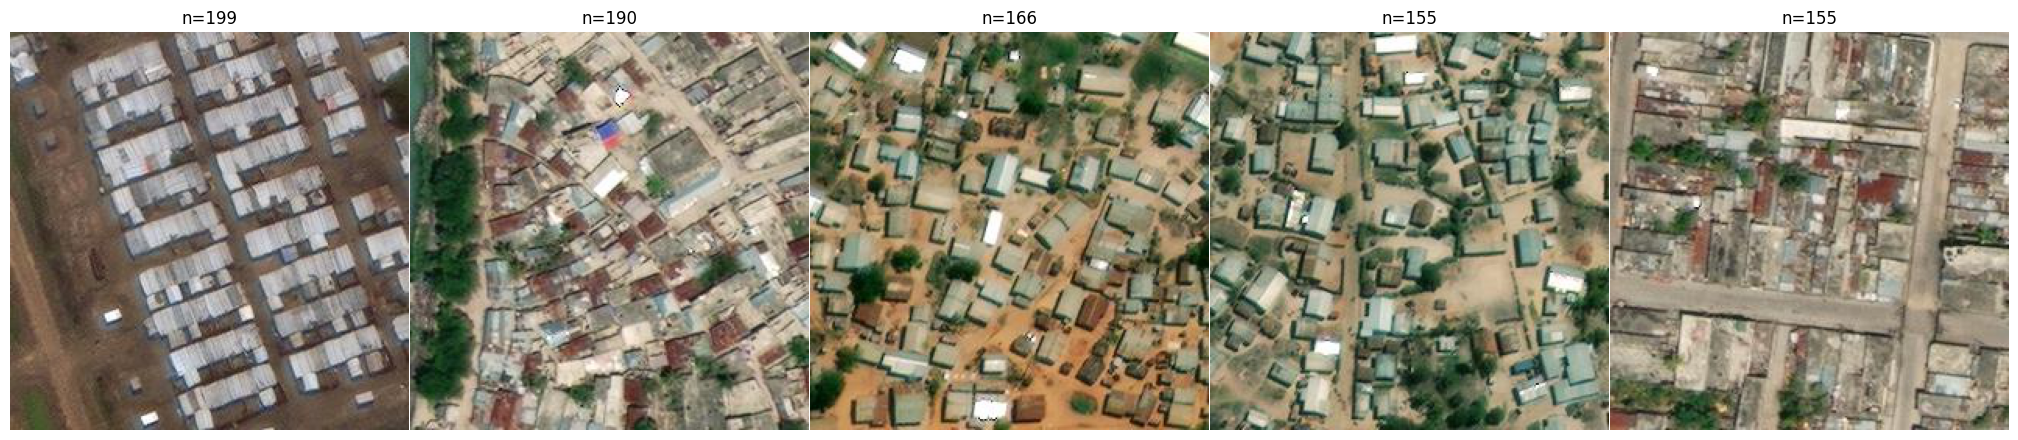

                                     fwp             base_folder  polygon_count
32ad7dcd-e91d-4937-8090-abd7c7e0fe98.tif ramp_bentiu_south_sudan            199
8e62bc7e-d9c3-4c80-bc5a-c0b9982e28ab.tif    ramp_les_cayes_haiti            190
876e39f1-7706-4ee1-bcb5-7c74383610ee.tif       ramp_mzuzu_malawi            166
e5fda4be-4f9b-4951-a02d-5ce3cc7c3e49.tif       ramp_mzuzu_malawi            155
d1f4d8a5-d95d-47ba-84ae-b1c5df69e4a3.tif    ramp_les_cayes_haiti            155


In [ ]:
# Sort the DataFrame by 'polygon_count' in descending order and take the top 5
top_chips = df.sort_values(by='polygon_count', ascending=False).head(5)

# Create a figure with multiple subplots
plt.figure(figsize=(20, 4))

# Loop through the top five entries
for index, chip in enumerate(top_chips.itertuples(), 1):
    ax = plt.subplot(1, 5, index)
    image = cv2.imread(chip.cwp, -1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title(f"n={chip.polygon_count}")
    ax.axis('off')

plt.tight_layout(pad=0)
plt.show()

# Print the top chips
print(top_chips[['fwp', 'base_folder', 'polygon_count']].to_string(index=False))

(256, 256, 3)
(256, 256, 3)


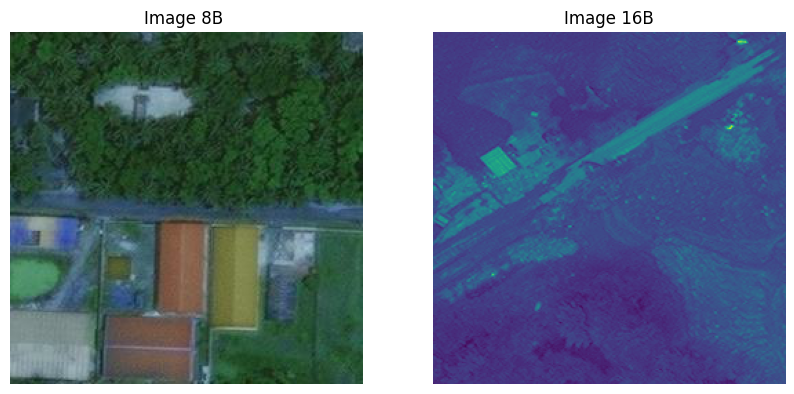

In [ ]:
# Examine an 8 and 16 bit images
t1 = 'ramp_data/ramp_barishal_bangladesh/source/0003d02a-6bf0-4790-ac29-eed4337fe430.tif'
t2 = 'ramp_data/ramp_shanghai_china/source/0a7d571e-0dec-44d1-b351-29fd38401591.tif'

# Show the first two images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(t1, -1))
plt.title('Image 8B ')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(t2, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH))
plt.title('Image 16B')
plt.axis('off')

print(cv2.imread(t1, -1).shape)
print(cv2.imread(t2).shape)

In [ ]:
def parse_coordinates(filename):
    """
    Parses a txt file containing coordinates and returns a list of coordinate pairs.

    Args:
        filename (str): The path to the file containing the coordinates.

    Returns:
        list: A list of coordinate pairs, where each pair is represented as a tuple of floats.

    """
    coordinates_list = []
    with open(filename, 'r') as file:
        for line in file:
            # Skip the first element which is the object type
            parts = line.split()[1:]
            # Use 1- for the y, because YOLO uses the top-left corner as the origin
            coords = [(float(parts[i]), 1-float(parts[i+1])) for i in range(0, len(parts), 2)]
            coordinates_list.append(coords)
    return coordinates_list

In [ ]:
def generate_yolo_image(jwp):
    """
    Generate a YOLO image by plotting coordinates on an input image.

    Parameters:
    jwp (str): The path to the input image file.

    Returns:
    None
    """

    # Check if the image file exists
    if os.path.exists(f'yolo_images/{os.path.basename(jwp)}'):
        return False

    # Read the image
    img = mpimg.imread(jwp)

    # Get the label file
    label_file = jwp.replace('images', 'labels').replace('.jpg', '.txt')

    # Read coordinates and prepare to plot
    coordinates_list = parse_coordinates(label_file)

    # Plotting the image and coordinates
    plt.figure()
    plt.imshow(img, extent=[0, 1, 0, 1])  # Assuming normalized coordinates

    # Plot the coordinates
    for coords in coordinates_list:
        xs, ys = zip(*coords)
        plt.plot(xs, ys, color='red')

    # Set the title
    plt.title(f'n= {len(coordinates_list)}')

    # Create a folder to save the output image if it does not exist
    os.makedirs('yolo_images', exist_ok=True)

    # Save the figure to a file
    plt.savefig(f'yolo_images/{os.path.basename(jwp)}', bbox_inches='tight')
    plt.close()

    # Explicitly call the garbage collector to free up memory
    del img
    gc.collect()

    return True

In [ ]:
# Define the path to the folders and find all folders
YOLO_FOLDERS = 'ramp_data_yolo/*/images'

# List to store all jpegs with path
jwps = []

# Collect all JPEG files from each folder and print the count in each folder
for folder in glob.glob(YOLO_FOLDERS, recursive=True):
    jpeg_files = glob.glob(f'{folder}/*.jpg')
    print(f'Folder {folder}: {len(jpeg_files)}')
    jwps.extend(jpeg_files)

# Display total count of JPEG files
print(f'Total count: {len(jwps)}\n')

# Create annotated images
print('Generating annotated images')
for jwp in tqdm(jwps):
    generate_yolo_image(jwp)

# Print the number of jpgs in the yolo_images folder
print(f'Number of jpgs in the yolo_images folder: {len(glob.glob("yolo_images/*.jpg"))}')

# Get a list of all the files in the yolo_images folder
yolo_images = glob.glob('yolo_images/*.jpg')
print(f'Number of yolo_images: {len(yolo_images)}')